## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp001'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 32 # 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

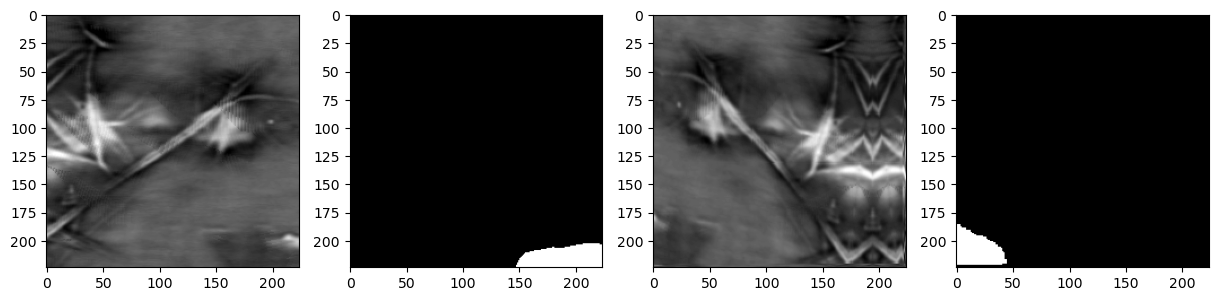

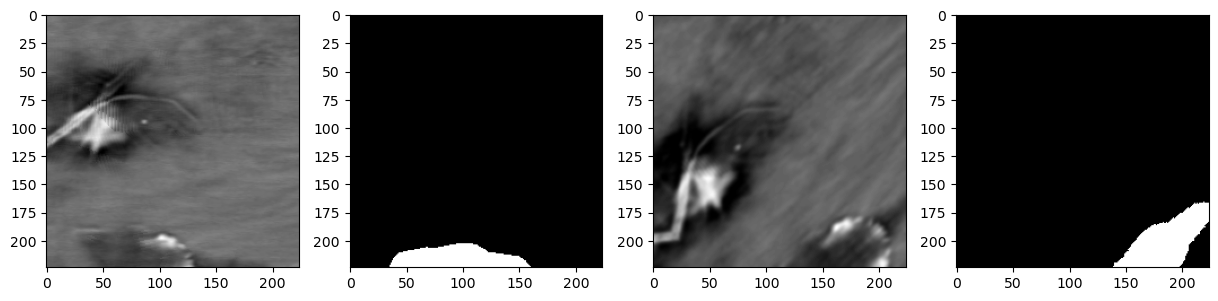

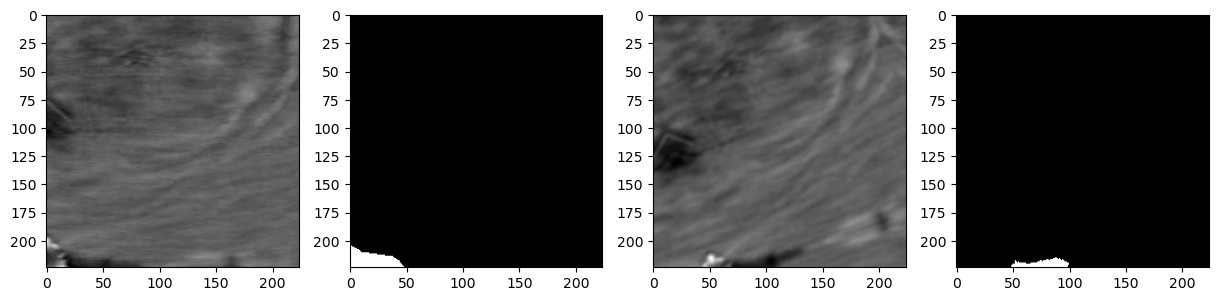

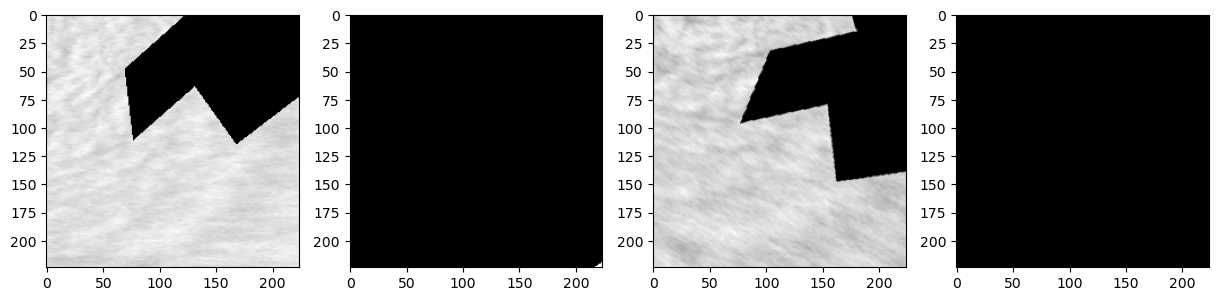

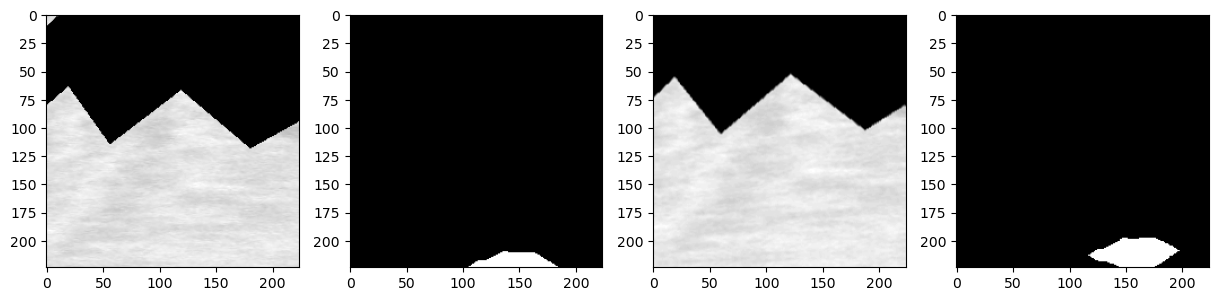

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096601853374353
th: 0.15, fbeta: 0.12096739833329348
th: 0.2, fbeta: 0.12103487312645292
th: 0.25, fbeta: 0.1981419018332123
th: 0.3, fbeta: 0.2374704098459145
th: 0.35, fbeta: 0.27572293236975015
th: 0.4, fbeta: 0.31255800447929954
th: 0.45, fbeta: 0.3472671951737573


best_th: 0.5, fbeta: 0.37326113345293505
Epoch 1 - avg_train_loss: 0.6140  avg_val_loss: 0.4432  time: 125s
Epoch 1 - avgScore: 0.3733
Epoch 1 - Save Best Score: 0.3733 Model
Epoch 1 - Save Best Loss: 0.4432 Model


th: 0.5, fbeta: 0.37326113345293505


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12096599953274481
th: 0.15, fbeta: 0.12096908295492628
th: 0.2, fbeta: 0.19069310074666054
th: 0.25, fbeta: 0.2306324158795681
th: 0.3, fbeta: 0.2815576697430875
th: 0.35, fbeta: 0.3221729046198615
th: 0.4, fbeta: 0.35356279567989995
th: 0.45, fbeta: 0.37877373970418027


best_th: 0.5, fbeta: 0.39825918607624033
Epoch 2 - avg_train_loss: 0.4338  avg_val_loss: 0.3971  time: 126s
Epoch 2 - avgScore: 0.3983
Epoch 2 - Save Best Score: 0.3983 Model
Epoch 2 - Save Best Loss: 0.3971 Model


th: 0.5, fbeta: 0.39825918607624033


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.32843834223155205
th: 0.15, fbeta: 0.37837179051993064
th: 0.2, fbeta: 0.4108786156851065
th: 0.25, fbeta: 0.4327933916437695
th: 0.3, fbeta: 0.4506542670713289
th: 0.35, fbeta: 0.4636835049890578
th: 0.4, fbeta: 0.469510910529305
th: 0.45, fbeta: 0.4724610851719247


best_th: 0.45, fbeta: 0.4724610851719247
Epoch 3 - avg_train_loss: 0.3115  avg_val_loss: 0.2518  time: 126s
Epoch 3 - avgScore: 0.4725
Epoch 3 - Save Best Score: 0.4725 Model
Epoch 3 - Save Best Loss: 0.2518 Model


th: 0.5, fbeta: 0.46855564799583493


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30100859880361236
th: 0.15, fbeta: 0.3453267553015228
th: 0.2, fbeta: 0.3823281975164014
th: 0.25, fbeta: 0.41420466009467766
th: 0.3, fbeta: 0.43798762557769993
th: 0.35, fbeta: 0.45711404316228577
th: 0.4, fbeta: 0.47859653883940095
th: 0.45, fbeta: 0.49218014182209796


best_th: 0.5, fbeta: 0.4933173899641313
Epoch 4 - avg_train_loss: 0.2419  avg_val_loss: 0.2379  time: 125s
Epoch 4 - avgScore: 0.4933
Epoch 4 - Save Best Score: 0.4933 Model
Epoch 4 - Save Best Loss: 0.2379 Model


th: 0.5, fbeta: 0.4933173899641313


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3814573648531678
th: 0.15, fbeta: 0.4271133792983743
th: 0.2, fbeta: 0.4651268871612168
th: 0.25, fbeta: 0.4980687598570209
th: 0.3, fbeta: 0.5171364882156407
th: 0.35, fbeta: 0.5254297491099955
th: 0.4, fbeta: 0.5251502455226766
th: 0.45, fbeta: 0.5177048057661707


best_th: 0.35, fbeta: 0.5254297491099955
Epoch 5 - avg_train_loss: 0.2192  avg_val_loss: 0.2429  time: 126s
Epoch 5 - avgScore: 0.5254
Epoch 5 - Save Best Score: 0.5254 Model
Epoch 5 - Save Best Loss: 0.2429 Model


th: 0.5, fbeta: 0.5005170243739918


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3515259166455095
th: 0.15, fbeta: 0.3988884883507816
th: 0.2, fbeta: 0.4323305920303883
th: 0.25, fbeta: 0.4632282160807207
th: 0.3, fbeta: 0.49003393435666315
th: 0.35, fbeta: 0.5105661148243078
th: 0.4, fbeta: 0.5225866373137351
th: 0.45, fbeta: 0.5307082358635312


best_th: 0.5, fbeta: 0.5329616896355126
Epoch 6 - avg_train_loss: 0.2035  avg_val_loss: 0.2267  time: 125s
Epoch 6 - avgScore: 0.5330
Epoch 6 - Save Best Score: 0.5330 Model
Epoch 6 - Save Best Loss: 0.2267 Model


th: 0.5, fbeta: 0.5329616896355126


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38334278464654553
th: 0.15, fbeta: 0.4077026862283489
th: 0.2, fbeta: 0.4234767433496601
th: 0.25, fbeta: 0.43649915517254534
th: 0.3, fbeta: 0.44994528155162467
th: 0.35, fbeta: 0.4577854542615092
th: 0.4, fbeta: 0.461238450762416
th: 0.45, fbeta: 0.4598562725618655


best_th: 0.4, fbeta: 0.461238450762416
Epoch 7 - avg_train_loss: 0.1890  avg_val_loss: 0.2667  time: 125s
Epoch 7 - avgScore: 0.4612


th: 0.5, fbeta: 0.4559764035630919


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46139861858861875
th: 0.15, fbeta: 0.5034512980738242
th: 0.2, fbeta: 0.5324002554713924
th: 0.25, fbeta: 0.550693156446437
th: 0.3, fbeta: 0.563309811941752
th: 0.35, fbeta: 0.5665759701285445
th: 0.4, fbeta: 0.5621108709564167
th: 0.45, fbeta: 0.5497690510216601


best_th: 0.35, fbeta: 0.5665759701285445
Epoch 8 - avg_train_loss: 0.1762  avg_val_loss: 0.2679  time: 125s
Epoch 8 - avgScore: 0.5666
Epoch 8 - Save Best Score: 0.5666 Model
Epoch 8 - Save Best Loss: 0.2679 Model


th: 0.5, fbeta: 0.5324572011011361


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41594416322290095
th: 0.15, fbeta: 0.4567646247582437
th: 0.2, fbeta: 0.4870224564610845
th: 0.25, fbeta: 0.510697052053131
th: 0.3, fbeta: 0.5302840120881365
th: 0.35, fbeta: 0.5478084440950425
th: 0.4, fbeta: 0.5589949513506929
th: 0.45, fbeta: 0.5658565267315875


best_th: 0.5, fbeta: 0.5689024134569076
Epoch 9 - avg_train_loss: 0.1621  avg_val_loss: 0.2414  time: 124s
Epoch 9 - avgScore: 0.5689
Epoch 9 - Save Best Score: 0.5689 Model
Epoch 9 - Save Best Loss: 0.2414 Model


th: 0.5, fbeta: 0.5689024134569076


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3377607610536633
th: 0.15, fbeta: 0.3648478286482785
th: 0.2, fbeta: 0.3870671187653443
th: 0.25, fbeta: 0.40686471811869684
th: 0.3, fbeta: 0.4257301291113704
th: 0.35, fbeta: 0.4445467656512094
th: 0.4, fbeta: 0.46393675033270865
th: 0.45, fbeta: 0.4834493979840829


best_th: 0.5, fbeta: 0.5013220691567626
Epoch 10 - avg_train_loss: 0.1508  avg_val_loss: 0.2591  time: 124s
Epoch 10 - avgScore: 0.5013


th: 0.5, fbeta: 0.5013220691567626


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4371201725045573
th: 0.15, fbeta: 0.47207025446055456
th: 0.2, fbeta: 0.4969736737224921
th: 0.25, fbeta: 0.5151195811396818
th: 0.3, fbeta: 0.5240170415216094
th: 0.35, fbeta: 0.5283767217600892
th: 0.4, fbeta: 0.5286748762909192
th: 0.45, fbeta: 0.5252039856922839


best_th: 0.4, fbeta: 0.5286748762909192
Epoch 11 - avg_train_loss: 0.1397  avg_val_loss: 0.2831  time: 125s
Epoch 11 - avgScore: 0.5287


th: 0.5, fbeta: 0.5179887068933392


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39231472420119157
th: 0.15, fbeta: 0.4217354671857981
th: 0.2, fbeta: 0.44740933452742104
th: 0.25, fbeta: 0.4718403438559892
th: 0.3, fbeta: 0.4918516944115728
th: 0.35, fbeta: 0.5097323615928178
th: 0.4, fbeta: 0.5253348797538475
th: 0.45, fbeta: 0.5361840614470675


best_th: 0.5, fbeta: 0.5395757783741212
Epoch 12 - avg_train_loss: 0.1317  avg_val_loss: 0.2733  time: 125s
Epoch 12 - avgScore: 0.5396


th: 0.5, fbeta: 0.5395757783741212


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39998716421272795
th: 0.15, fbeta: 0.4296898202864423
th: 0.2, fbeta: 0.4538630416861966
th: 0.25, fbeta: 0.47579883802948375
th: 0.3, fbeta: 0.4946990645045577
th: 0.35, fbeta: 0.5108294157169058
th: 0.4, fbeta: 0.5244770919532542
th: 0.45, fbeta: 0.5341822976167373


best_th: 0.5, fbeta: 0.5378154570729378
Epoch 13 - avg_train_loss: 0.1217  avg_val_loss: 0.2816  time: 125s
Epoch 13 - avgScore: 0.5378


th: 0.5, fbeta: 0.5378154570729378


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45162279737804206
th: 0.15, fbeta: 0.4795528646795843
th: 0.2, fbeta: 0.5001287517718318
th: 0.25, fbeta: 0.5134168050993762
th: 0.3, fbeta: 0.5207339235688653
th: 0.35, fbeta: 0.5246405555844792
th: 0.4, fbeta: 0.5247425356704581
th: 0.45, fbeta: 0.5195413807545751


best_th: 0.4, fbeta: 0.5247425356704581
Epoch 14 - avg_train_loss: 0.1173  avg_val_loss: 0.3208  time: 126s
Epoch 14 - avgScore: 0.5247


th: 0.5, fbeta: 0.5114923509901756


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41380964401223047
th: 0.15, fbeta: 0.4427835643195428
th: 0.2, fbeta: 0.4651348126650198
th: 0.25, fbeta: 0.48361465073436916
th: 0.3, fbeta: 0.5011485691530231
th: 0.35, fbeta: 0.5136839865990134
th: 0.4, fbeta: 0.5231247824765829
th: 0.45, fbeta: 0.5255607800007119


best_th: 0.45, fbeta: 0.5255607800007119
Epoch 15 - avg_train_loss: 0.1106  avg_val_loss: 0.2989  time: 125s
Epoch 15 - avgScore: 0.5256


th: 0.5, fbeta: 0.5225654443429824


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.41594416322290095
th: 0.15, fbeta: 0.4567646247582437
th: 0.2, fbeta: 0.4870224564610845
th: 0.25, fbeta: 0.510697052053131
th: 0.3, fbeta: 0.5302840120881365
th: 0.35, fbeta: 0.5478084440950425
th: 0.4, fbeta: 0.5589949513506929
th: 0.45, fbeta: 0.5658565267315875


best_th: 0.5, fbeta: 0.5689024134569076


th: 0.5, fbeta: 0.5689024134569076


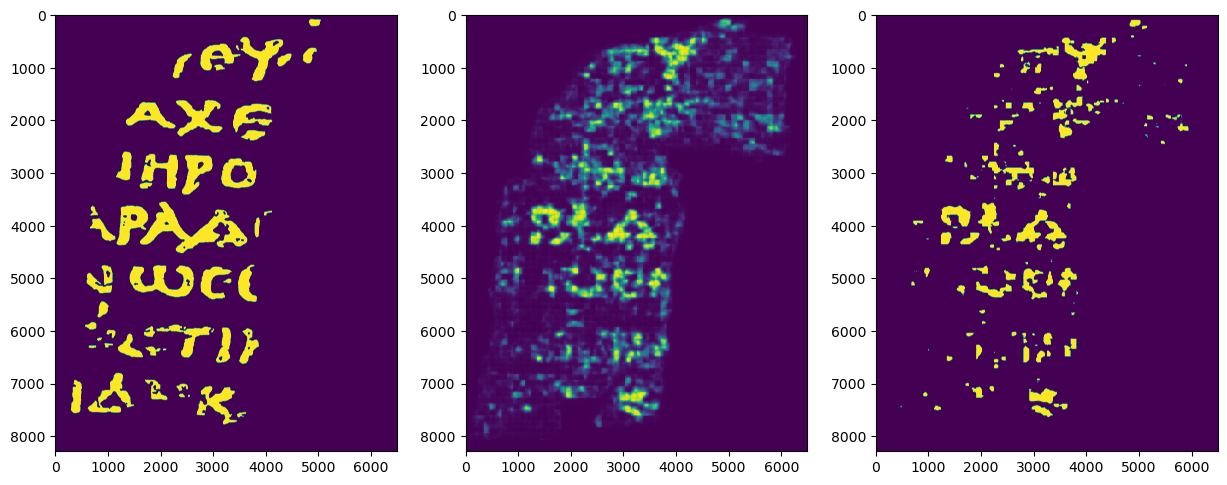

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([40070840.,  3925996.,  2007363.,  1310599.,   999340.,   792979.,
          655870.,   552800.,   475856.,   408824.,   345095.,   297647.,
          259344.,   243978.,   242839.,   250657.,   253816.,   264585.,
          292043.,   188377.]),
 array([1.15155121e-04, 4.99508430e-02, 9.97865310e-02, 1.49622219e-01,
        1.99457907e-01, 2.49293595e-01, 2.99129283e-01, 3.48964971e-01,
        3.98800659e-01, 4.48636346e-01, 4.98472034e-01, 5.48307722e-01,
        5.98143410e-01, 6.47979098e-01, 6.97814786e-01, 7.47650474e-01,
        7.97486162e-01, 8.47321850e-01, 8.97157538e-01, 9.46993226e-01,
        9.96828914e-01]),
 <BarContainer object of 20 artists>)

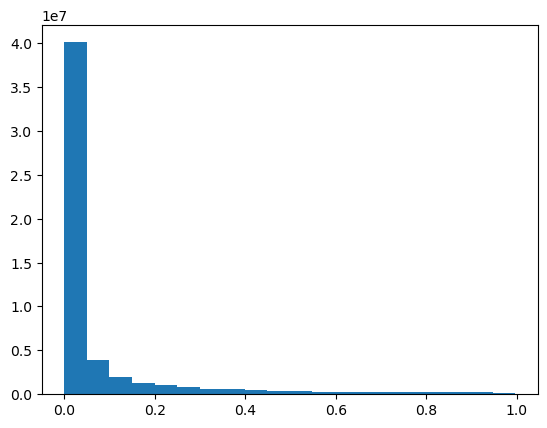

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000